---
title: "1D Forward Simulation for a Single Sounding"
authors:
  - id: devincowan
---

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Keywords:** DC resistivity, forward simulation, apparent resistivity, 1D sounding, wires mapping.

</br>

**Summary:** Here we use the module [simpeg.electromagnetics.static.resistivity](xref:simpeg#simpeg.electromagnetics.static.resistivity) to simulate 1D apparent resistivity data for a 1D Wenner array. The [Simulation1DLayers](xref:simpeg#simpeg.electromagnetics.static.resistivity.simulation_1d.Simulation1DLayers) class is used to solve the problem via a semi-analytic Hankel transform solution.

</br>

**Learning Objectives:**

- Introduce the fundamentals of simulating DC resistivity data with SimPEG.
- Introduce the basics of defining DC resistivity surveys in SimPEG.
- Demonstrate various approaches for defining a 1D layered Earth model.
- Demonstrate how the Earth's electrical properties can be defined according to conductivity OR resistivity.
- How to simulate the data as normalize voltages OR apparent resistivities.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [simpeg.electromagnetics.static.resistivity](xref:simpeg#simpeg.electromagnetics.static.resistivity).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils).

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 16})

write_output = False

## Define the Survey

DC resistivity surveys within SimPEG require the user to create and connect three types of objects:

- [receivers](xref:simpeg#simpeg.electromagnetics.static.resistivity.receivers.BaseRx): which defines the locations of the potential (or MN) electrodes and the type of data; e.g. 'volt' for normalized voltage in V/A or 'apparent_resistivity' for apparent resistivity in $\Omega m$. *Note only M electrode locations are needed to define pole receivers*.
- [sources](xref:simpeg#simpeg.electromagnetics.static.resistivity.sources.BaseSrc): which defines the locations of the current (or AB) electrodes, and their associated receivers. *Note only A electrode locations are needed to define pole sources*.
- [survey](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey): the object which stores and organizes all of the sources and receivers.

Each datum corresponds to a unique pair of current and potential electrodes. When running the 1D forward simulation, the horizontal position is taken into account and we assume the electrodes are placed at the Earth's surface. Therefore electrode locations can be defined by an xyz location, but the vertical position is ignored.

In [2]:
# Define the 'a' spacings for Wenner array and number of soundings
a_min = 20.0
a_max = 500.0
n_stations = 25
electrode_separations = np.linspace(a_min, a_max, n_stations)

source_list = []  # create empty array for sources to live
for ii in range(0, len(electrode_separations)):
    # Extract separation parameter for sources and receivers
    a = electrode_separations[ii]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-1.5 * a, 0.0, 0.0]
    B_location = np.r_[1.5 * a, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-0.5 * a, 0.0, 0.0]
    N_location = np.r_[0.5 * a, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

We can extract various objects and properties from the objects used to generate the survey. As we can see, all receivers associated with each source are defined within a single object.

In [3]:
print("# of locations: {}".format(survey.nSrc))  # number of sources
print("# of data: {}".format(survey.nD))  # number of data that will be simulated
print(survey.source_list[3])  # the 3rd source object
print(survey.source_list[3].receiver_list[0])  # Its receiver

# of locations: 25
# of data: 25
Dipole(a: [-120.    0.    0.]; b: [120.   0.   0.])
Dipole(m: [-40.   0.   0.]; n: [40.  0.  0.])


## Define a 1D Layered Earth Model

In SimPEG, a 1D layered Earth is defined by the set of layer thicknesses and the physical properties for each layer. Thicknesses and physical property values are defined from the top layer down. If we have N layers, we define N physical property values and N-1 layer thicknesses. The lowest layer is assumed to extend to infinity. In the case of a halfspace, the layer thicknesses would be an empty array.

In [4]:
# Define layer thicknesses.
layer_thicknesses = np.r_[100.0, 100.0]

# Define layer resistivities.
layer_resistivities = np.r_[1e3, 4e3, 2e2]

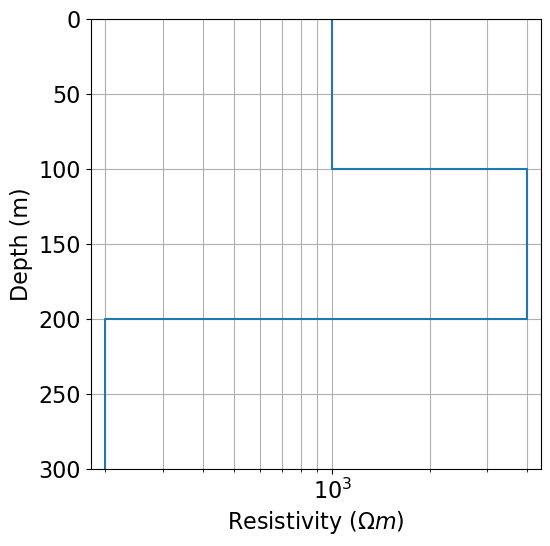

In [5]:
ax = plot_1d_layer_model(layer_thicknesses, layer_resistivities)
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
plt.show()

## Define a Model and Mapping

In SimPEG, the term 'model' is not necessarily synonymous with a set of physical property values. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](xref:numpy#numpy.ndarray) whose lengths are equal to the number of model parameters.

Classes within the ``simpeg.maps`` module are used to define the mapping that connects the model to the parameters required to run the DC resistivity simulation; i.e. layer thicknesses and layer conductivities/resistivities. Here, we demonstrate two types of mappings and models that may be used for 1D DC resistivity simulation.

**1. Resistivity model:** For forward simulation, the easiest approach is to define the model as the layer resistivities and hard-code the layer thicknesses into simulation. In this case, the mapping from the model to the resistivities is defined using the [simpeg.maps.IdentityMap](xref:simpeg#simpeg.maps.IdentityMap) class.

**2. Parametric layered Earth model:** In this case, the model defines the layer thicknesses and log-conductivities. We therefore need a mapping that extracts layer thicknesses from the model, and a mapping that extracts log-conductivities from the model and converts them into conductivities. For this, we require the [simpeg.maps.Wires](xref:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mapping classes. Note that successive mappings can be chained together using the $*$ operator.

In [6]:
# Define mapping for a resistivity model.
resistivity_model = layer_resistivities.copy()
resistivity_map = maps.IdentityMap(nP=len(layer_resistivities))

# Define mappings for parametric model with log-resistivities
parametric_model = np.r_[layer_thicknesses, np.log(1 / layer_resistivities)]
wire_map = maps.Wires(
    ("thicknesses", len(layer_thicknesses)),
    ("log_conductivity", len(layer_resistivities)),
)
thicknesses_map = wire_map.thicknesses
log_conductivity_map = maps.ExpMap() * wire_map.log_conductivity

## Define the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. Here, we use the [Simulation1DLayers](xref:simpeg#simpeg.electromagnetics.static.resistivity.Simulation1DLayers) which simulates the data according to a 1D Hankel transform solution. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the layer thicknesses
- the layer conductivities/resistivities

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Here, we define two simulation objects.

**1. Resistivity model simulation:** Here, the model parameters are the layer resistivities. ``rhoMap`` is used to define the mapping from the model to the layer resistivities. And ``thicknessess`` is used to set the layer thicknesses as static parameters of the simulation.

**2. Parametric model simulation:** Here we are working with conductivities as opposed to resistivities, and the model contains layer thicknesses and log-conductivities. In this case, ``sigmaMap`` is used to define the mapping from the model to the layer conductivities. And ``thicknessesMap`` is used to define the mapping from the model to the layer thicknesses.

In [7]:
simulation_resistivity = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=resistivity_map,
    thicknesses=layer_thicknesses,
)

In [8]:
simulation_parametric = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    sigmaMap=log_conductivity_map,
    thicknessesMap=thicknesses_map,
)

## Predict DC Resistivity Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](xref:simpeg#simpeg.simulation.BaseSimulation.dpred) method. Note that despite the difference in how we defined the model, the data predicted by both simulations is equivalent because data are being modeled for the same 1D layered Earth.

In [9]:
dpred_resistivity = simulation_resistivity.dpred(resistivity_model)
dpred_parametric = simulation_parametric.dpred(parametric_model)

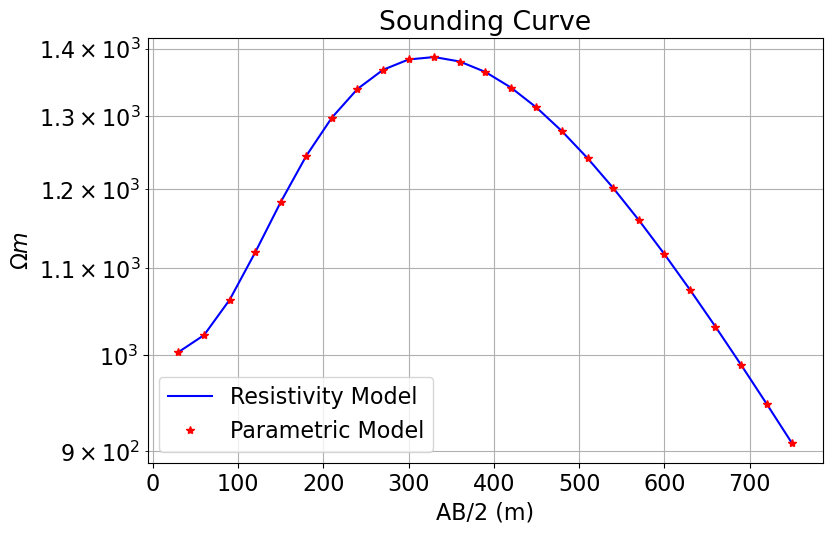

In [10]:
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.semilogy(1.5 * electrode_separations, dpred_resistivity, "b")
ax1.semilogy(1.5 * electrode_separations, dpred_parametric, "r*")
ax1.grid(True, which="both")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"$\Omega m$")
ax1.set_title("Sounding Curve")
ax1.legend(["Resistivity Model", "Parametric Model"])
plt.show()

**Optional:** Export Data

In [11]:
if write_output:
    dir_path = os.path.sep.join([".", "fwd_dcr_1d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    rng = np.random.default_rng(seed=145)
    noise = rng.normal(scale=0.025 * dpred_resistivity, size=len(dpred_resistivity))

    data_array = np.c_[
        survey.locations_a,
        survey.locations_b,
        survey.locations_m,
        survey.locations_n,
        dpred_resistivity + noise,
    ]

    fname = dir_path + "app_res_1d_data.dobs"
    np.savetxt(fname, data_array, fmt="%.4e")